# The effect of adding a diffuse foreground

Zachary Martinot and the HERA Validation Team

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Setup-and-Metadata" data-toc-modified-id="Setup-and-Metadata-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Setup and Metadata</a></span><ul class="toc-item"><li><span><a href="#Abstract" data-toc-modified-id="Abstract-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Abstract</a></span></li><li><span><a href="#Imports" data-toc-modified-id="Imports-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Imports</a></span></li><li><span><a href="#Description" data-toc-modified-id="Description-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Description</a></span></li><li><span><a href="#Summary" data-toc-modified-id="Summary-1.4"><span class="toc-item-num">1.4&nbsp;&nbsp;</span>Summary</a></span></li><li><span><a href="#Software" data-toc-modified-id="Software-1.5"><span class="toc-item-num">1.5&nbsp;&nbsp;</span>Software</a></span></li><li><span><a href="#Data" data-toc-modified-id="Data-1.6"><span class="toc-item-num">1.6&nbsp;&nbsp;</span>Data</a></span></li><li><span><a href="#General-Functions" data-toc-modified-id="General-Functions-1.7"><span class="toc-item-num">1.7&nbsp;&nbsp;</span>General Functions</a></span></li></ul></li><li><span><a href="#Power-spectrum-of-foreground-+-signal" data-toc-modified-id="Power-spectrum-of-foreground-+-signal-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Power spectrum of foreground + signal</a></span><ul class="toc-item"><li><span><a href="#plots" data-toc-modified-id="plots-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>plots</a></span></li></ul></li><li><span><a href="#Residuals" data-toc-modified-id="Residuals-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Residuals</a></span></li></ul></div>

## Setup and Metadata

### Abstract

This notebook shows that adding a realisitic diffuse foreground to the sky has the expected effect of dominating the signal at low $k$ while leaving a high $k$ region that is uncorrupted to within the cosmic variance of the signal.

### Imports

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime

import h5py
import os

import hera_pspec as hps
import pyuvdata

import copy

In [2]:
from scipy.special import i0 as bessel_i0

In [3]:
kaiser6 = lambda x, L: bessel_i0(np.pi * 6 * np.sqrt(1-(2*x/(L-1) - 1)**2)) / bessel_i0(np.pi * 6)
hps.pspecdata.aipy.dsp.WINDOW_FUNC['kaiser6'] = kaiser6

In [4]:
%%javascript
MathJax.Hub.Config({
    TeX: { equationNumbers: { autoNumber: "AMS" } }
});
MathJax.Hub.Queue(
  ["resetEquationNumbers", MathJax.InputJax.TeX],
  ["PreProcess", MathJax.Hub],
  ["Reprocess", MathJax.Hub]
);

<IPython.core.display.Javascript object>

### Description

In [5]:
print("Last executed: %s"%str(datetime.now()))

Last executed: 2019-08-13 17:06:50.511865


- **Major Step Description:** {Insert standard description of major step}
- **Minor Variation Description:** {Insert standard description of minor step}
- **Pipelines Tested:** {Brief list of explicit pipelines tested in the notebook}
- **Criteria**:
  1. {Explicit Criterion for success 1}
  2. {Explicit Criterion for success 2}
  

### Summary

The results of this validation test, in reference to the outlined criteria, are
1. {Test results for criteria 1}
2. {Test results for criteria 2...}

{Brief notes on anything else interesting that was noted during testing}

### Software

HERA software used in this validation test, with associate git commit hash:

* {``pyuvdata``: `a8f6b6fdd7261`}
* {If you have the Python Markdown extension, you can do this: ``pyuvdata``: ``{pyuvdata.version.git_hash}``
* {``hera_qm``: `f3e32c3cef36cbd`}
* {etc.}

Versions of other software used in this validation test:

* {``numpy``: vx.x.x}
* {etc. (only list imported modules).}

### Data

The following paths reflect the exact locations of all data used in this test:

In [6]:
# Path to the fiducial signal visibility realization
sig_vis_data_path = '/lustre/aoc/projects/hera/Validation/hera_hex37_100-200MHz_HERA_dipole_beam_pow_neg2_pspec/realization_0.uvh5'
assert os.path.exists(sig_vis_data_path)

# Path to the diffuse foreground visibility
for_vis_data_path = '/lustre/aoc/projects/hera/Validation/hera_hex37_100-200MHz_HERA_dipole_eGSM_preview/hera_hex37_egsm_preview.uvh5'
assert os.path.exists(for_vis_data_path)

In [7]:
# Path to beam normalization data
omegas_data_path = '/lustre/aoc/projects/hera/Validation/HERA_dipole_Omegas/HERA_dipole_Omegas.h5'
assert os.path.exists(omegas_data_path)

### General Functions

In [8]:
# get a Vokes-I uvdata object from the input uvh5 file
def get_VI_data(vis_data_path):
    uvd = pyuvdata.UVData()
    uvd.read_uvh5(vis_data_path)
    
    # one of these days...
    xx_integer = pyuvdata.utils.polstr2num('xx')
    yy_integer = pyuvdata.utils.polstr2num('yy')
    
    xx_ind = np.argwhere(uvd.polarization_array == xx_integer)[0][0]
    yy_ind = np.argwhere(uvd.polarization_array == yy_integer)[0][0]
    
    VI_data = uvd.data_array[:,:,:,xx_ind] + uvd.data_array[:,:,:,yy_ind]
    
    uvd.select(polarizations=(-5))
    uvd.polarization_array[0] = 1
    uvd.data_array = VI_data.reshape(VI_data.shape + (1,))
    
    return uvd

In [9]:
# This is the cosmological parameter set in the input simulation
def astropyPlanck15_for_hera_pspec():
    H0 = 67.74
    h = H0/100.

    Om_b = 0.02230/h**2.
    Om_c = 0.1188/h**2.
    Om_L = 0.6911
    Om_k = 1. - (Om_b + Om_c + Om_L)

    hps_cosmo = hps.conversions.Cosmo_Conversions(Om_L=Om_L,
                                                Om_b=Om_b,
                                                Om_c=Om_c,
                                                H0=H0,)
    return hps_cosmo

The cosmological signal visibilities have an input power spectrum
$P(k) = A_0 k^{-2}$, we can redefine the power spectrum to have a redshift dependent power spectrum $P(k,z) = (1+z)^2 A_0 k^{-2}$ by scaling the visibility by a factor of $1+z = \frac{\nu_e}{\nu}$

In [35]:
def redefine_cosmological_signal(uvd):
    nu_e = 1420405751.7667 # Hz
    nu_hz = uvd.freq_array[0]
    
    uvd.data_array *= (nu_e/nu_hz)[None,None,:,None]
    return

## Power spectrum of foreground + signal

In [10]:
%%time
uvdI_s = get_VI_data(sig_vis_data_path)

uvdI_f = get_VI_data(for_vis_data_path)

Telescope RIMEz calculation is not in known_telescopes.


CPU times: user 38min 39s, sys: 3min 57s, total: 42min 37s
Wall time: 16min 37s


In [36]:
redefine_cosmological_signal(uvdI_s)

In [ ]:
plt.plot(uvdI_s)

In [37]:
lst_2_to_8_inds = np.where(np.logical_and(
    uvdI_s.lst_array < 8. * np.pi/12.,
    uvdI_s.lst_array > 2. * np.pi/12.))

In [38]:
times_use = np.unique(uvdI_s.time_array[lst_2_to_8_inds])

In [39]:
cosmo = astropyPlanck15_for_hera_pspec()

In [40]:
uvdI = copy.deepcopy(uvdI_s)

uvdI.data_array += uvdI_f.data_array

uvdI.select(times=times_use, inplace=True)

In [41]:
uvdI_fc = copy.deepcopy(uvdI_f)

uvdI_fc.select(times=times_use, inplace=True)

In [42]:
# Load beam data
with h5py.File(omegas_data_path, 'r') as h5f:
    Omega = h5f['Omega'].value
    Omegapp = h5f['Omegapp'].value

hpsb = hps.pspecbeam.PSpecBeamFromArray(Omega, Omegapp, uvdI.freq_array[0], cosmo=cosmo)

In [43]:
# Convert visibility data from Jansky to milikelvin *at the source*
nu_e = 1420405751.7667 # Hz
nu_hz = uvdI.freq_array[0]

# conversion to mK at the observer
Jy_to_mK = hpsb.Jy_to_mK(nu_hz, pol='pI')

# conversion to mK at the source
Jy_to_mK_src = (nu_e/nu_hz) * Jy_to_mK

In [44]:
uvdI.data_array *= Jy_to_mK_src[None,None,:,None]

In [45]:
uvdI_fc.data_array *= Jy_to_mK_src[None,None,:,None]

In [46]:
ds = hps.PSpecData(dsets=[uvdI, uvdI], wgts=[None,None], beam=hpsb)

ds.dsets[0].vis_units = 'mK'
ds.dsets[1].vis_units = 'mK'

In [47]:
ds_fc = hps.PSpecData(dsets=[uvdI_fc, uvdI_fc], wgts=[None,None], beam=hpsb)

ds_fc.dsets[0].vis_units = 'mK'
ds_fc.dsets[1].vis_units = 'mK'

In [48]:
bl_lengths = []
bl_use = []
for (i,j) in uvdI.get_antpairs():
    b = np.linalg.norm(uvdI.antenna_positions[i] - uvdI.antenna_positions[j])
    
    bl_lengths.append(b)
    
    if b <= 88.2-0*14.7:
        bl_use.append(True)
    else:
        bl_use.append(False)

In [49]:
# 63 unique baselines, excluding auto-correlation
# ant_pairs = [ant_pair for ant_pair in uvdI.get_antpairs() if ant_pair[0] != ant_pair[1]]

# 5 ~20MHz bandwidth spectral windows
# edge_inds = [np.argmin(np.abs(nu_hz - nu_i)) for nu_i in 1e6*np.linspace(100.,200.,6, endpoint=True)]
# spw_ranges = zip(edge_inds, edge_inds[1:])

ant_pairs = [ant_pair for i,ant_pair in enumerate(uvdI.get_antpairs()) if ant_pair[0] != ant_pair[1] and bl_use[i]]

# 7 ~15MHz bandwidth spectral windows
edge_inds = [np.argmin(np.abs(nu_hz - nu_i)) for nu_i in 1e6*np.linspace(100.,200.,8, endpoint=True)]
spw_ranges = zip(edge_inds, edge_inds[1:])

In [50]:
print len(ant_pairs)

63


In [89]:
%%time
uvp = ds.pspec(ant_pairs, ant_pairs, 
               dsets=(0,1),
               pols=('pI', 'pI'),
               spw_ranges=spw_ranges,
               input_data_weight='identity',
               norm='I',
               taper='blackman-harris',
               verbose=False,
               little_h=False)

CPU times: user 2h 9min 53s, sys: 3min 45s, total: 2h 13min 38s
Wall time: 7min 58s


In [90]:
%%time
uvp_fc = ds_fc.pspec(ant_pairs, ant_pairs, 
               dsets=(0,1),
               pols=('pI', 'pI'),
               spw_ranges=spw_ranges,
               input_data_weight='identity',
               norm='I',
               taper='blackman-harris',
               verbose=False,
               little_h=False)

CPU times: user 2h 10min 32s, sys: 3min 52s, total: 2h 14min 24s
Wall time: 8min 5s


In [91]:
blpair_group = [sorted(np.unique(uvp.blpair_array))]

uvp_avg = uvp.average_spectra(blpair_groups=blpair_group, time_avg=True, inplace=False)

uvp_avg.fold_spectra()

In [92]:
uvp_fc_avg = uvp_fc.average_spectra(blpair_groups=blpair_group, time_avg=True, inplace=False)

uvp_fc_avg.fold_spectra()

In [93]:
keys = uvp_avg.get_all_keys()

In [94]:
pspec_est, pspec_f, k_est, k_est_lh = {}, {}, {}, {}

r_samples, dr_samples = {}, {}
ks_alt = {}

for spw in uvp_avg.data_array.keys():
    pspec_est[spw] = uvp_avg.get_data(keys[spw])[0]
    pspec_f[spw] = uvp_fc_avg.get_data(keys[spw])[0]
    k_est[spw] = uvp_avg.get_kparas(spw, little_h=False)
    k_est_lh[spw] = uvp_avg.get_kparas(spw, little_h=True)
    
    i0,i1 = spw_ranges[spw]
    spw_freqs = uvp_avg.freq_array[i0:i1]
    z_s = cosmo.f2z(spw_freqs)
    r_samples[spw] = np.array([cosmo.DC(z, little_h=False) for z in z_s])
    dr_samples[spw] = np.diff(r_samples[spw])
    
    ks_alt[spw] = np.pi*np.mean(1./np.abs(dr_samples[spw]))

In [95]:
max_tau_g = 88.2 / 2.99e8 # seconds

max_k_g = {}
for spw in k_est:
    i0,i1 = spw_ranges[spw]
    spw_freqs = uvp_avg.freq_array[i0:i1]
    mid_freq = np.mean(spw_freqs)
    z_mid = cosmo.f2z(mid_freq)
    max_k_g[spw] = max_tau_g * cosmo.tau_to_kpara(z_mid, little_h=False)

In [96]:
max_k_g

{0: 0.09063135285505713,
 1: 0.09650519727519914,
 2: 0.10205259540453662,
 3: 0.10734433088319945,
 4: 0.11240244303258927,
 5: 0.11724373647295809,
 6: 0.12191252920163019}

In [97]:
def aliased_power_spectrum(k, k_nyquist):
    A0 = 1e1 * (1./0.2)**-2.
    
    Pk = 1e6*A0 * (np.pi)**2. * 1./(2. * k_nyquist * np.sin(np.pi*k / k_nyquist /2.))**2.
    return Pk

In [99]:
def aliased_power_spectrum_alt(k, k_nyquist, z):
    A0 = 1e1 * (1./0.2)**-2.
    
    Pk = 1e6*A0 * (np.pi)**2. * 1./(2. * k_nyquist * np.sin(np.pi*k / k_nyquist /2.))**2.
    Pk *= (1+z)**2.
    return Pk

### plots

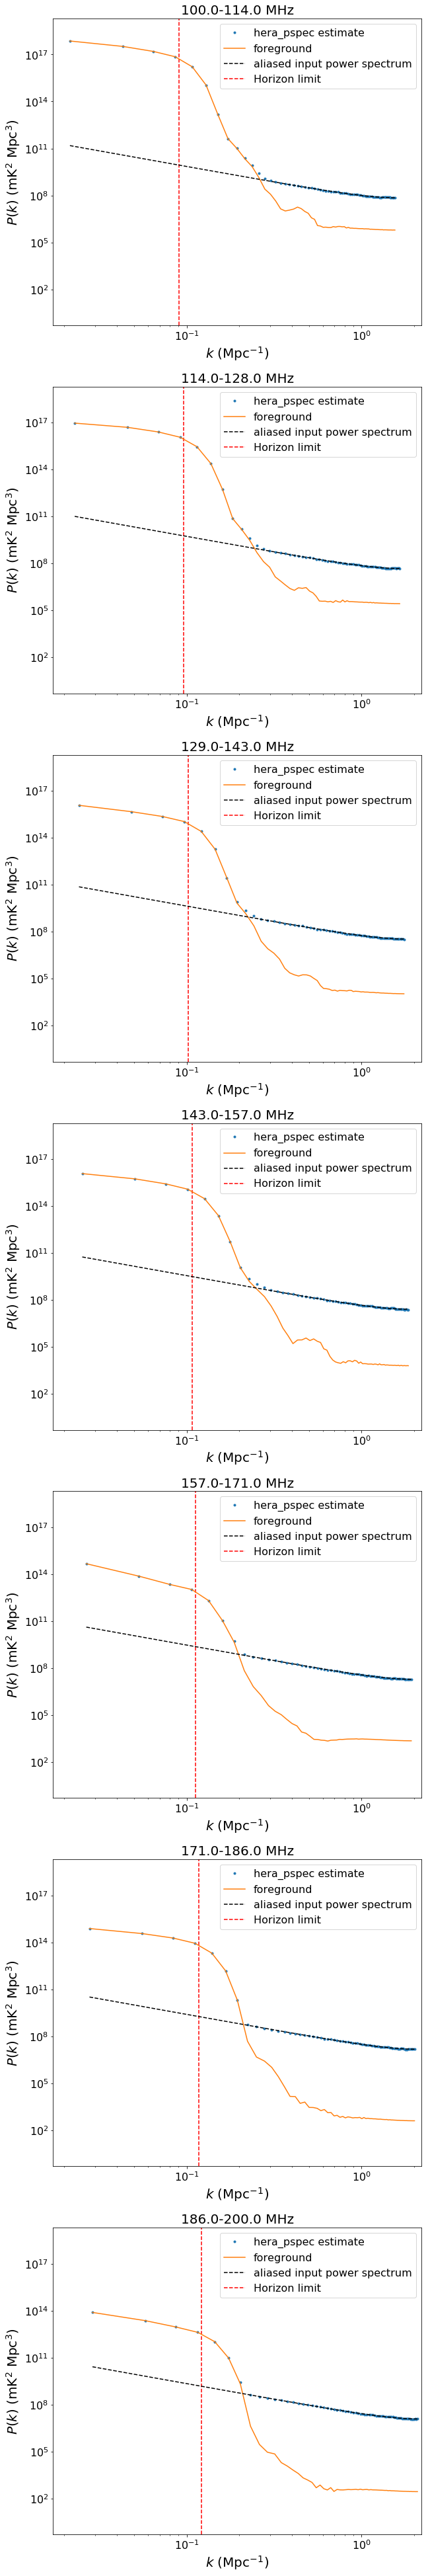

In [100]:
fig = plt.figure(figsize=(10,10*len(pspec_est.keys())))
for spw in pspec_est.keys():
    
    i0,i1 = spw_ranges[spw]
    spw_freqs = uvp.freq_array[i0:i1]
    z_mean = uvp.cosmo.f2z(np.mean(spw_freqs))
    
    ax = fig.add_subplot(len(pspec_est.keys()),1,spw+1)
    ax.tick_params(labelsize=16)
    ax.plot(k_est[spw], pspec_est[spw], '.', label='hera_pspec estimate')
    ax.plot(k_est[spw], pspec_f[spw], '-', label='foreground')

    ax.plot(k_est[spw], aliased_power_spectrum_alt(k_est[spw], ks_alt[spw], z_mean), '--k', label='aliased input power spectrum')
    
    plt.vlines(max_k_g[spw], ymin=0.5e0, ymax=2e19, color='r', linestyle='--', label='Horizon limit')
    
    plt.yscale('log')
    plt.ylim(0.5e0,2e19)
    
    plt.xscale('log')
    plt.xlim(np.amin(k_est[0])*0.8,2.2)
#     plt.xlim(-0.1, 2.2)

    nu0, nu1 = np.around(spw_freqs[0]*1e-6,0), np.around(spw_freqs[-1]*1e-6,0)
    title_str = '{0}-{1} MHz'.format(str(nu0), str(nu1))
    plt.title(title_str, fontsize=20)
    plt.xlabel(r'$k$ (Mpc$^{-1}$)', fontsize=20)
    plt.ylabel(r'$P(k)$ (mK$^2$ Mpc$^3$)', fontsize=20)
    plt.legend(fontsize=16)
    
plt.show()

## Residuals

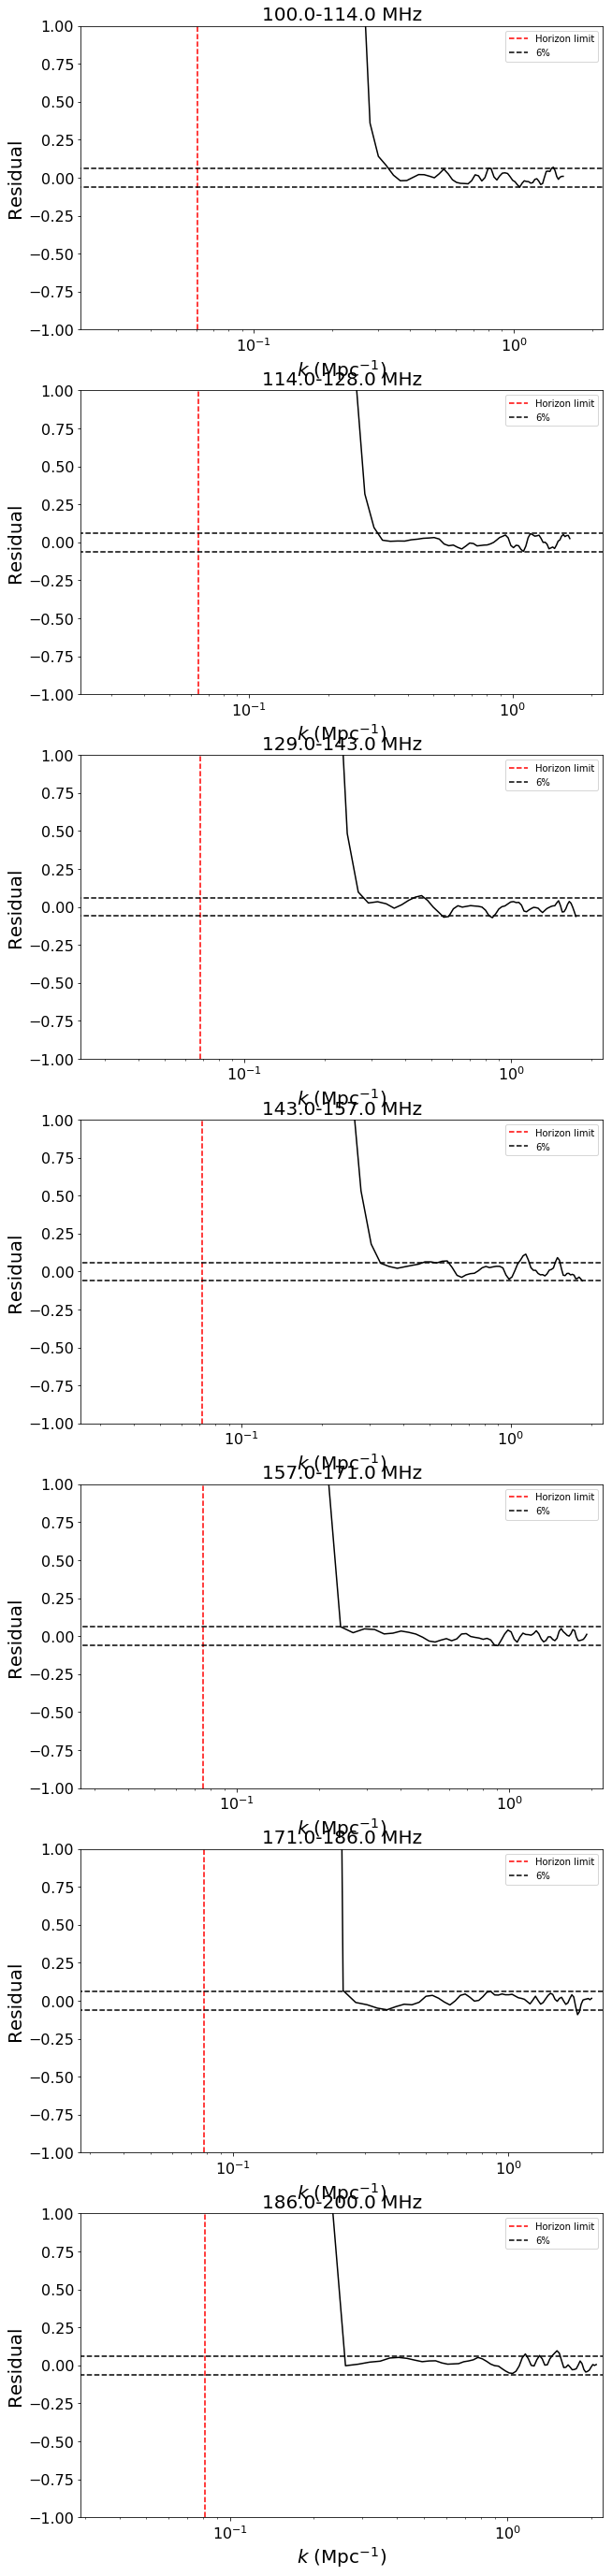

In [79]:
fig = plt.figure(figsize=(10,7*len(pspec_est.keys())))
for spw in pspec_est.keys():
    ax = fig.add_subplot(len(pspec_est.keys()),1,spw+1)
    ax.tick_params(labelsize=16)
    
    i0,i1 = spw_ranges[spw]
    spw_freqs = uvp.freq_array[i0:i1]
    z_mean = uvp.cosmo.f2z(np.mean(spw_freqs))
    
    aliased_truth = aliased_power_spectrum_alt(k_est[spw], ks_alt[spw], z_mean)
    res_aliased = (pspec_est[spw] - aliased_truth)/aliased_truth

    ax.plot(k_est[spw], res_aliased, '-k')
    plt.vlines(max_k_g[spw], ymin=-1.,ymax=1., color='r', linestyle='--', label='Horizon limit')

    plt.hlines([-0.06,0.06],xmin=-0.1,xmax=2.2, linestyle='--', label='6%')

    plt.ylim(-1.,1.)
    
    plt.xscale('log')
    plt.xlim(-0.1,2.2)
    
    plt.legend()
    
    nu0, nu1 = np.around(spw_freqs[0]*1e-6,0), np.around(spw_freqs[-1]*1e-6,0)
    title_str = '{0}-{1} MHz'.format(str(nu0), str(nu1))
    plt.title(title_str, fontsize=20)
    
    plt.ylabel('Residual', fontsize=20)
    plt.xlabel(r'$k$ (Mpc$^{-1}$)', fontsize=20)
    
#     print np.std(all_res[spw].real), np.amax(all_res[spw].real)
plt.show()